In [9]:
from gpad_data_generation import *
import numpy as np
import scipy.io as sio
from Funcoes_de_EA import *
import pandas as pd
import os
import time
import pydub
import wave
import matplotlib.pyplot as plt

## gpad_data_generation module

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import madmom
import pywt
import pywt.data
from scipy import signal
from pydub import AudioSegment

def convert_mp3_to_wav(filename):
    """
    converts a mp3 file to a wav file
    
    Arguments:
    filename -- string with the name of the mp3 file
                e.g.: filename = "/Music/saudade.mp3"
    
    Returns: 
    /~/filename.wav
    """
    sound = AudioSegment.from_mp3(filename)
    soundwav = sound.export(filename[:-4] + ".wav", format="wav")
    soundwav.close()

def music_loading(filename, sample_rate=44100):
    """
    loads one music to the memory as a normalized numpy array
    
    Arguments:
    filename    -- string with the name of the mp3 file
                   e.g.: filename = "/Music/saudade.mp3"
    sample_rate -- [OPTIONAL] sample rate of the music in Hertz
    
    Returns: 
    musica      -- a numpy array of dimensions (n,1) with n the number of samples of the music
    """
    
    sig = madmom.audio.signal.Signal(filename, sample_rate = sample_rate, num_channels = 1)
    musica = np.array(sig)
    musica = musica/np.max(np.abs(musica))
    return musica

def ODF_SuperFlux(signal, sample_rate, frame_size, hop):
    """
    computes the Onset Detection Function of a signal
    
    Arguments:
    signal      -- a numpy array of dimensions (n,1)
    sample_rate -- sample rate of the signal in Hertz
    frame_size  -- size in samples of the frames that will build the spectogram
    hop         -- distance in samples between the frame i+1 and the frame i
    
    Returns: 
    ODF         -- a numpy array of dimension (n,1) with n the number of samples of the ODF
    """
    
    # Loading a file with desired sample_rate and down-mixed
    sig = madmom.audio.signal.Signal(signal, sample_rate = sample_rate, num_channels = 1)

    # We frame the signal
    frames = madmom.audio.signal.FramedSignal(sig, frame_size=frame_size, hop=hop)

    # We compute the log filtered spectrogram of each frame, the number of bands is fixed based in the documentation
    log_filt_spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram(frames, num_bands = 24)

    # We compute the ODF presented in Bock et tal (2013)
    odf_raw = madmom.features.onsets.superflux(log_filt_spec)
    odf_raw = np.array(odf_raw)
    ODF = odf_raw / np.max(odf_raw)
    
    return ODF

def PeDF(ODF, form):
    """
    computes the Periodicity Function, a normalized autocorrelation of the ODF signal
    
    Arguments:
    ODF         -- a numpy array of dimensions (n,1)
    form        -- definition of PeDF calculation
                    'full'    -> The output will be a symetric signal, the full autocorrelation
                    'partial' -> The output will be one half of the full autocorrelation
    
    Returns: 
    PeDF        -- a numpy array of dimension (n,1) with n the number of samples of the PeDF
    """
    
    corr = signal.correlate(ODF, ODF, mode='same', method='direct')
    corr = corr / np.max(corr)
    
    if form == "full":
        PeDF = corr
        return PeDF
    if form == "partial":
        index = np.where(corr == 1)
        index = index[0][0]
        PeDF = corr[index:]
        return PeDF

def preprocess(signal_we_want_to_analyze, nivel_wavelet):
    """
    realizes the preprocessing of a signal to output its ODFs, PeDFs and wavelet coefficients
    
    Arguments:
    signal_we_want_to_analyze  -- a numpy array of dimensions (n,1)
    nivel_wavelet              -- the level of the wavelet transform
    
    Returns: 
    ODF_SET                    -- a list containing ODFs functions
    PeDF_FULL_SET              -- a list containing the whole PeDFs functions
    PeDF_PARTIAL_SET           -- a list containing the halfs of the PeDFs functions
    coeffs                     -- the wavelet coefficients of the wavelet transform decomposition over "signal_we_want_to_analyze"
    
    """
    
    # Wavelet Decomposition
    N = nivel_wavelet
    coif3 = pywt.Wavelet('coif3')
    coeffs = pywt.wavedec(signal_we_want_to_analyze, coif3, level = N) #cAN, cDN, cD(N-1), cD(N-2), .... based in level = N

    # ODF Generation

    # Empty list of ODFs
    ODF_SET = []
    for index in range(0,len(coeffs)):
        coeff_to_odf = coeffs[index]
        sample_rate = 44100
        frame_size = 4096 #92.8ms

        if index == 0:
            samplerate_equivalente = sample_rate/2**(len(coeffs)-1)
            frame_size_equivalente = frame_size/2**(len(coeffs)-1)
        else:
            samplerate_equivalente = sample_rate/2**(len(coeffs)-index)
            frame_size_equivalente = frame_size/2**(len(coeffs)-index)

        ODF = ODF_SuperFlux(coeff_to_odf, samplerate_equivalente, frame_size_equivalente, frame_size_equivalente/2)
        ODF_SET.append(ODF)

    # PeDF Generation 
    PeDF_FULL_SET = []
    PeDF_PARTIAL_SET = []
    for index in range(0,len(ODF_SET)):
        PeDF1 = PeDF(ODF_SET[index], form = "full")
        PeDF2 = PeDF(ODF_SET[index], form = "partial")
        PeDF_FULL_SET.append(PeDF1)
        PeDF_PARTIAL_SET.append(PeDF2)
    
    return ODF_SET, PeDF_FULL_SET, PeDF_PARTIAL_SET, coeffs

def music_processor(filename, start_sample=2**19, final_sample=2**20, sample_rate=44100, nivel_wavelet = 5):
    """
    realizes the preprocessing of a music file's segment to output its ODFs, PeDFs and wavelet coefficients
    
    Arguments:
    filename                   -- string with the name of the mp3 file
                                  e.g.: filename = "/Music/saudade.mp3"
    start_sample               -- [OPTIONAL] starting sample of the audio segment exctracted of "file"
    final_sample               -- [OPTIONAL] final sample of the audio segment exctracted of "file"
    sample_rate                -- [OPTIONAL] the sample rate of "file"
    nivel_wavelet              -- [OPTIONAL] the level of the wavelet transform decomposition
    
    Returns: 
    ODF_SET                    -- a list containing ODFs functions
    PeDF_FULL_SET              -- a list containing the whole PeDFs functions
    PeDF_PARTIAL_SET           -- a list containing the halfs of the PeDFs functions
    coeffs                     -- the wavelet coefficients of the wavelet transform over "signal_we_want_to_analyze"
    
    """
    
    musica_inteira = music_loading(filename, sample_rate)
    musica = musica_inteira[start_sample:final_sample]
    
    ODF_SET, PeDF_FULL_SET, PeDF_PARTIAL_SET, coeffs = preprocess(musica, nivel_wavelet)
    
    return ODF_SET, PeDF_FULL_SET, PeDF_PARTIAL_SET, coeffs

def plot_ODF(ODF, index=None, size=None):
    """
    realizes the plotting of the ODF
    
    Arguments:
    ODF        -- a numpy array of dimensions (n,1)
    index      -- the ODF level corresponding to its wavelet coefficients
    size       -- the level of the wavelet decomposition that generated all the ODFs
    
    Returns: 
    the plot of the ODF in (samples,Onset Stregth) 
    
    """
    
    
    plt.figure()
    plt.plot(ODF)
    plt.title('ODF')
    plt.ylabel('Onset Strength')
    plt.xlabel('Samples')
        
    if index and size != None:
            if index == 0:
                name = "cA" + str(size-1)
                plt.title('ODF - ' + name)
            else:
                name = "cD" + str(size-index)
                plt.title('ODF - ' + name)
    else:
        plt.title('ODF')

def plot_PeDF(PeDF, form, index=None, size=None):
    
    """
    realizes the plotting of the PeDF
    
    Arguments:
    ODF        -- a numpy array of dimensions (n,1)
    form       -- 'total' or 'partial', related to the PeDF's aspect
    index      -- the PeDF level corresponding to its wavelet coefficients
    size       -- the level of the wavelet decomposition that generated all the PeDFs
    
    Returns: 
    the plot of the PeDF in (lags,autocorrelation probability) 
    
    """
    
    if form == "full":
        plt.figure()
        x1 = np.arange(-len(PeDF)/2, len(PeDF)/2,1)
        plt.plot(x1,PeDF)
        
        if index and size != None:
            if index == 0:
                name = "cA" + str(size-1)
                plt.title('PeDF - Total - ' + name)
            else:
                name = "cD" + str(size-index)
                plt.title('PeDF - Total - ' + name)
        else:
            plt.title('PeDF - Total')
        plt.xlabel('Lags')
            
    if form == "partial":
        plt.figure()
        plt.plot(PeDF)
        
        if index and size != None:
            if index == 0:
                name = "cA" + str(size-1)
                plt.title('PeDF - Partial - ' + name)
            else:
                name = "cD" + str(size-index)
                plt.title('PeDF - Partial - ' + name)
        else:
            plt.title('PeDF - Total')
        plt.xlabel('Lags')



# Funcoes EA

In [19]:

# coding: utf-8

# # Funções de Extração de Atributos
# 
# Esse código tem por propósito reunir todas as funções de extração de atributos para alimentação da MLP. Esses atributos são:
# 
#  - **Atributo 1: v_eta**, ou a Média;
#  - **Atributo 2: v_sigma**, ou Desvio Dadrão;
#  - **Atributo 3: v_mu**, ou Moda;
#  - **Atributo 4: v_sc**, ou Centróide Espectral;
#  - **Atributo 5: v_ss**, ou Espalhamento Espectral;
#  - **Atributo 6: v_SSk**, ou Skewness Espectral;
#  - **Atributo 7: v_ThCR**, ou Taxa de Cruzamento por Limiar (Th=0);
#  - **Atributo 8: v_SCF**, ou Spectral Crest Factor;
#  - **Atributo 9: v_SR**, ou Spectral Rollof;
#  - **Atributo 10: v_SD**, ou Spectral Decrease;
#  - **Atributo 11: v_SF**, ou Spectral Flatness;
#  - **Atributo 12: v_PR**, ou Predictivity Ratio;
#  - **Atributo 13: v_ERf1**, ou Espectro Rítmico (freq. do máximo >0.5Hz).
#  
# Cada um dos atributos é extraído por uma função individual que serão então invocadas por uma função *master* que receberá as PeDFs do banco de dados. 
# 
# > Durante o desenvolvimento, os códigos originais desenvolvidos em MATLAB pelo professor Antônio estarão acima das células que contém (ou conterão) os códigos em Python. 
# 

# ### Importações

# In[1]:


import numpy as np
from scipy import stats
from scipy import signal
from scipy.fft import fft
import scipy.io as sio
from matplotlib import mlab
import matplotlib.pyplot as plt



# In[2]:


def delta(x):
    local = signal.find_peaks(x)
    delta_pks = np.diff(local[0])
    
    return delta_pks


def EspectroAmplitude(x):
    
    l = np.size(x)
    nfft = int(np.power(2,np.ceil(np.log2(l))))
    X = fft(x, nfft)
    X = X[1:int(nfft/2)+1]
    EA = np.absolute(X)
    
    return EA, nfft
    


# ### Atributo 1: v_eta ou Média
# O código do professor para extração de média não foi feito através de uma função "original", mas pela função `mean` do MATLAB diretamente na função *master*. Aqui, por consistência, será feito através da função `v_eta`. O código abaixo se refere a uma das vezes em que a função `mean` foi utilizada no código do professor.
# 
# ![Cálculo da Média](img/v_eta.png)
# 
# ```sh
# v_eta_PeDFA5(k)=mean(Delta1);
# ```

# In[3]:


def v_eta(x):
    return np.mean(x)


# ### Atributo 2: v_sigma ou Desvio Padrão
# O código do professor para extração de desvio padrão não foi feito através de uma função "original", mas pela função `std` do MATLAB diretamente na função *master*. Aqui, por consistência, será feito através da função `v_sigma`. O código abaixo se refere a uma das vezes em que a função `std` foi utilizada no código do professor.
# 
# ![Cálculo do Desvio Padrão](img/v_sigma.png)
# 
# ```sh
# v_sigma_PeDFA5(k)=std(Delta1,1); %O número 1 em std(x,1) é um flag indicando sqrt((x-eta_x)^2)/N, onde N é número de amostras
# ```

# In[4]:


def v_sigma(x):
    return np.std(x)


# ### Atributo 3: v_mu ou Moda
# O código do professor para extração de moda não foi feito através de uma função "original", mas pela função `mode` do MATLAB diretamente na função *master*. Aqui, por consistência, será feito através da função `v_mu`. O código abaixo se refere a uma das vezes em que a função `mode` foi utilizada no código do professor.
# ```sh
# v_mu_PeDFA5(k)=mode(Delta1); %Quando há valores múltiplos ocorrendo com frequência igual, MODE retorna o menor destes valores
# ```

# In[5]:


def v_mu(x):
    return stats.mode(x).mode[0]


# ### Atributo 4: v_sc ou Centróide Espectral
# 
# ![Cálculo do Centróide Espectral](img/v_sc.png)
# 
# ```sh
# %==========================================================================
# %> @resum Programa para Cálculo de Centróide Espectral 
# %>         
# %> 
# %> @param X: vetor ou matriz cujas colunas sejam Espectro de Amplitude
# %> @param hertz: "1" se deseja-se v_sc em hertz, "0" ou vazio caso contrá-
# %>               rio, ou omitido.
# %> @param niveldwt: para cáculo da taxa de amostragem equivalente ao nível 
# %>                  DWT.
# %> @retval v_sc: vetor linha com cetróides espectrais das colunas de X.
# %>               
# %==========================================================================
# function [v_sc,v_sc_Hz] = v_sc(X,niveldwt,h)
# 
# if nargin<3 || isempty(h), h=128; end
# 
# f_s_eq=44100/((2^niveldwt)*h);
# 
# X = X.^2;
#     v_sc = ([0:size(X,1)-1]*X)./sum(X,1);
#     
#     % avoid NaN for silence frames
#     v_sc (sum(X,1) == 0) = 0;
#     
#     if niveldwt~=0,
#         % convert from index to Hz
#         v_sc_Hz     = v_sc / size(X,1) * f_s_eq/2;
#     else
#         v_sc_Hz=v_sc;
#     end
#     
#      
# end
# ```

# In[6]:


def v_sc(x, niveldwt, h = 128, hertz = True):
    
    
    f_s_eq = 44100/((np.power(2, niveldwt))*h)
    
    
    x = np.power(x,2)
    
    
    v_sc = np.divide((np.matmul((np.arange(np.size(x))),(x))),(np.sum(x)))
    
    if hertz:
        v_sc = v_sc / (np.size(x)-1)  * f_s_eq/2
        
    
    return v_sc


# In[7]:


def FeatureSpectralCentroid(X, niveldwt, h=128):

    f_s = 44100/((np.power(2, niveldwt))*h)
    
    isSpectrum = X.ndim == 1

    #X = X**2 removed for consistency with book

    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc


# ### Atributo 5: v_ss ou Espalhamento Espectral
# ```sh
# %==========================================================================
# %> @resum Calcula o Espalhamento Espectral considerando um único frame
# %> 
# %>
# %> @param X: Espectrograma (dimensão NFFT X musicas)
# %> @param f_s: taxa de amostragem da função 
# %>
# %> @valret v_SS: espalhamento Espectral (em índice ou Hz)
# %==========================================================================
# function [vSS] = v_SS(X,hertz,niveldwt,f_s,h)
# 
# if nargin<2 || isempty(hertz), hertz=0; end
# 
# if nargin<4 || isempty(f_s), f_s=44100; end
# 
# if nargin<5 || isempty(h), h=128; end
# 
# f_s_eq=f_s/((2^niveldwt)*h);
# %f_s_eq=44100;
# 
#     % usa o centróide espectral como índice
#     vsc=v_sc(X,0);
# 
#     % pré-alocação de memória
#     vSS=zeros(size(vsc));
#  
#     % cálculo do espalhamento
#     X=X.^2;
#     for mus = 1:size(X,2)
#         vSS(mus)=(([0:size(X,1)-1]-vsc(mus)).^2*X(:,mus))./sum(X(:,mus));
#     end
#     
#     vSS=sqrt(vSS);
#     
#     if hertz==1
#     % converte de índice para Hz
#     vSS=vSS / size(X,1) * f_s_eq/2;
#     end
#     
# end
# ```

# In[8]:


def v_ss(x, niveldwt, hertz=True, f_s=44100, h=128):
    
    #v_ss2 = FeatureSpectralSpread(x, niveldwt)
    
    f_s_eq = f_s/((np.power(2, niveldwt))*h)
    
    vsc = v_sc(x,niveldwt, hertz=False)
    
    x = np.power(x,2)
    
    norm=np.sum(x)
    indices = np.arange(np.size(x))
    v_ss = np.matmul(((indices-vsc)**2) , (x))/(norm) 
    
    v_ss = np.sqrt(v_ss)
    
    if hertz:
        v_ss = v_ss/(np.size(x)) * f_s_eq/2
    
    
    
    return v_ss


# In[9]:


def FeatureSpectralSpread(X, niveldwt, h=128):

    f_s = 44100/((np.power(2, niveldwt))*h)
    
    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    # get spectral centroid as index
    vsc = v_sc(X, niveldwt, hertz=False)
    X = X**2 #removed for consistency with book

    print(vsc)
    norm = X.sum(axis=0)
    norm[norm == 0] = 1

    # compute spread
    indices = np.arange(0, X.shape[0])
    vss = np.dot((indices - vsc)**2, X) / norm
    
    vss = np.sqrt(vss)

    # convert from index to Hz
    vss = vss / (X.shape[0]-1) * f_s / 2

    return np.squeeze(vss) if isSpectrum else vss


# ### Atributo 6: v_SSk ou Skewness Espectral
# ![Cálculo do Skewness Espectral](img/v_ssk.png)
# 
# ```sh
# %>=========================================================================
# %> @resum Skewness: calcula a assimetria da pdf de uma PeDF unilateral  
# %>         
# %>
# %> @param x: vetor ou matriz com PeDFs em suas colunas 
# %>
# %> @valret v_Sk: 
# %>=========================================================================
# 
# function [v_Sk] = vSk(x)
# 
# %x_unilateral=x((size(x,1)-1)/2+1:size(x,1),:);
# 
#     for n=1:size(x,2)
#         v_Sk(:,n)=(1/(std(x(:,n).^3.*size(x,1))))*sum((detrend(x(:,n),'constant')).^3);
#     end
#     
# end
# ```

# In[10]:


def v_ssk(x):
    
    x = signal.detrend(x,type='constant')
    v_ssk = (np.sum(np.power(x, 3))) / (np.multiply(np.power( np.std(x) ,3), x.size))
    
    return v_ssk


# In[11]:


def FeatureSpectralSkewness(X, niveldwt, f_s=44100, UseBookDefinition=False):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    if UseBookDefinition:  # not recommended
        # compute mean and standard deviation
        mu_x = np.mean(X, axis=0, keepdims=True)
        std_x = np.std(X, axis=0)

        # remove mean
        X = X - mu_x

        # compute kurtosis
        vssk = np.sum(X**3, axis=0) / (std_x**3 * X.shape[0])
    else:
        f = np.arange(0, X.shape[0]) / (X.shape[0] - 1) * f_s / 2
        # get spectral centroid and spread (mean and std of dist)
        vsc = v_sc(X,niveldwt) 
        print(vsc)
        vss = v_ss(X, niveldwt)   
        print(vss)

        norm = X.sum(axis=0)
        norm[norm == 0] = 1
        vss[vss == 0] = 1

        # compute spread
        vssk = np.zeros(X.shape[1])
        for n in range(0, X.shape[1]):
            vssk[n] = np.dot((f - vsc[n])**3, X[:, n]) / (vss[n]**3 * norm[n] * X.shape[0])

    return vssk


# ### Atributo 7: v_ThCR ou v_zcr ou Taxa de Cruzamento por Zero
# 
# ![Cálculo da Taxa de Cruzamento por Zero](img/v_zcr.png)
# 
# ```sh
# % =========================================================================
# %> @resum calcula a taxa de cruzamento ascendente por zero média,
# %>        e em cada frame
# %> 
# %>
# %> @param PeDF: Matriz PeDF ou Vetor PeDF em análise
# %> @param Cf: comprimento do frame em amostras (ou Cpedf)
# %> @param h: comprimento do hop em amostras
# %> @param Thres: limiar (threshold) em relação ao valor rms da PeDF sobre o
# %>               qual os cruzamentos são computados. Padrão PeDFrms.
# %> @valret vzc_media: zero crossing rate médio
# %> @valret vzc: vetor com os ZCR para cada frame
# %> @valret t: tempo hop
# % =========================================================================
# 
# function [vet_vzc_media,vzc_media,vzc] = vzcrPeDF(PeDFx, Cf, h, Thres) 
#  
# mus=size(PeDFx,2);
# vet_vzc_media=zeros(1,mus);
# 
# for k=1:mus
# 
#     PeDF=PeDFx(:,k);
#     Th=Thres*sqrt(mean(PeDF.^2)); %porcentagem do valor rms
#     
#     if nargin<4, Th=sqrt(mean(PeDF.^2)); end %Limiar (threshold) default: rms da PeDF
#     
#     if isempty(h)==true,
#         h=0;
#         Nf=1;
#     elseif isempty(h)==false,
#         % Número de frames
#         Nf=1;%ceil(size(PeDF,1)/h);
#     end
#     
#     %     % calcula o instante do hop
#     %     t               = ((0:Nf-1) * h + (Cf/2))/fs;
#     
#     % pré-alocação
#    % vzc             = zeros(1,Nf);
#     
#     for n = 1:Nf
#         i_start     = (n-1)*h + 1; %início dos frames
#         i_stop      = min(length(PeDF),i_start + Cf - 1);
#         
#         % calcula a zero crossing rate
#         d=(diff(sign(PeDF(i_start:i_stop)-Th)));
#         d(d<=0)=0;
#         d(d==2)=1;
#         vzc(n)=mean(d);
#     end
#     
#     vzc_media=mean(vzc);
#     vet_vzc_media(:,k)=vzc_media;
# end       
# end
# ```

# In[12]:


def v_zcr(x, Cf, h=0, threshold = 0):
    
    th = threshold*np.sqrt(np.mean(np.power(x,2))) #porcentagem do valor rms
    
    d = np.diff(np.sign(x-th))
    #print(d)
    
    for i in range(len(d)):
        if d[i] <= 0:
            d[i] = 0
        if d[i] == 2:
            d[i] = 1
    #print(d)   
    v_zcr = np.mean(d)
    
    
    
    return v_zcr


# ### Atributo 8: v_scf ou Fator do Espectro de Magnitude
#  
#  ![Cálculo do Spectral Crest Factor](img/v_scf.png)
#  
# ```sh
#  % =========================================================================
# %> @resum calcula o spectral crest factor do espectro de magnitude
# %> chamada por: AtributosPeDF_v1.m
# %>
# %> @param X: matriz (módulo das FFT das PeDF nas Colunas)
# %> 
# %>
# %> @valret vtsc spectral crest factor
# % =========================================================================
# function [vtsc] = v_SCF (X)
# 
#    vtsc = max(X,[],1) ./ sum(X,1);
# end
# ```

# In[13]:


def v_scf(x):
    v_scf = np.divide(np.amax(x), np.sum(x))
    return v_scf


# ### Atributo 9: v_sr ou Spectral Rolloff
# 
# ![Cálculo do Spectral Rollof](img/v_sr.png)
# 
# ```sh
# % ======================================================================
# %> @resum calcula o rolloff espectral do espectro de magnitude 
# %> chamado por: AtributosPeDF_v1
# %>
# %> @param X: matriz (módulo das FFT das PeDF nas Colunas)
# %> @param f_s: taxa de amostragem do áudio original 
# %>
# %> @valret vsr: spectral rolloff (em Hz)
# % ======================================================================
# function [vsr] = v_SR (X, kappa,niveldwt, f_s, h)
# 
# if nargin<5 || isempty(h), h=128; end
# if nargin<4 || isempty(f_s), f_s=44100; end
# if nargin<2 || isempty(kappa), kappa=.85; end
#     
# f_s_eq=f_s/((2^niveldwt)*h);
# %f_s_eq=44100;
#     % pré-alocação
#     vsr     = zeros(1,size(X,2));
#   
#     %calcula rolloff
#     resultSum   = sum(X,1);
#     for (n = 1:length(vsr))
#         vsr(n)  = find(cumsum(X(:,n)) >= kappa*resultSum(n), 1); 
#     end
#     
#     % convert from index to Hz
#     vsr     = vsr / size(X,1) * f_s_eq/2;
# end
# ```

# In[14]:


def v_sr(x, niveldwt, kappa = .85, f_s = 44100, h=128):
    
    f_s_eq = f_s/((np.power(2, niveldwt))*h)
    
    #calculo
    v_sr = np.argwhere(np.cumsum(x)>=kappa*np.sum(x))[0][0]
    
    #conversao de index para Hz
    v_sr = v_sr/(x.size-1) * f_s_eq/2
    
    return v_sr


# ### Atributo 10: v_sd ou Spectral Decrease (**)
# 
# 
# 
# ```sh
# % ======================================================================
# %> @resum calcula o spectral decrease de um espectro de magnitude er
# %>        relação a vERf1
# %> chamado por: AtributosPeDF_v1
# %>
# %> @param X: matriz (módulo das FFT das PeDF nas Colunas)
# %> 
# %>
# %> @valret vSD: spectral decrease (vSD<=1)
# % ======================================================================
# function [vSD] = v_sd (X,f_s_eq,NFFT)
# 
# %if nargin<2 || isempty(f_s), f_s=44100; end
# 
# f_R=f_s_eq./NFFT;
# 
# indice=floor(0.5/f_R);
# 
# X1=X(indice:end,:); %Elimina frequências abaixo de 0.5Hz do Espectro Rítmico
# 
# [~,iMaxMod]=max(X1,[],1);
# 
# X2=X1(iMaxMod:end,:);
# 
# 
# 
#     % calcula o índice do vetor
#     k       = [0:size(X2,1)-1];
#     k(1)    = 1;
#     kinv    = 1./k;
#     
#     % calcula a inclinação
#     vSD     = (kinv*(X2-repmat(X2(1,:),size(X2,1),1)))./sum(X2(2:end,:),1);
# end
# ```

# In[1]:


def v_sd(X, niveldwt, NFFT, f_s=44100, h=128):
    
    
    f_s_eq = f_s/((np.power(2, niveldwt))*h)
    
    f_R = f_s_eq/NFFT
    indice = int(np.floor(0.5/f_R))
    x1 = X[indice:]
    iMaxMod = np.argmax(x1)
    x2 = x1[iMaxMod:]
    
    # compute index vector
    kinv = np.arange(0, np.size(x2))
    kinv[0] = 1
    kinv = 1 / kinv

    norm = x2[2:].sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    # compute slope
    #print(kinv.shape)
    #print(x2.shape)
    v_sd = np.tile(x2[0], (np.size(x2), 1)) 
    vsd = np.dot(kinv, x2-v_sd) / norm

    return FeatureSpectralDecrease(X, f_s_eq)
    
         


# In[16]:


#CÓDIGO ALEXANDER LERCH
def FeatureSpectralDecrease(X, f_s):

    # compute index vector
    kinv = np.arange(0, X.shape[0])
    kinv[0] = 1
    kinv = 1 / kinv

    norm = X[1:].sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    # compute slope
    vsd = np.dot(kinv, X - X[0]) / norm

    return np.squeeze(vsd, axis=0)


# ### Atributo 11: v_sf ou Spectral Flatness (**)
# 
# ![Cálculo do Spectral Flatness](img/v_sf.png)
# 
# ```sh
# % ======================================================================
# %> @resum Calcula o spectral flatness do espectro de magnitude 
# %> chamado por: AtributosPeDF_v1
# %>
# %> @param X: matriz (módulo das FFT das PeDF nas Colunas)
# %> @param f_s: taxa de amostragem do áudio original (sem uso)
# %>
# %> @retval vtf: spectral flatness
# % ======================================================================
# function [vsf] = v_SF (X, f_s)
# 
# if nargin<2 || isempty(f_s), f_s=44100; end
# 
#     XLog    = log(X+1e-20);
#     vsf     = exp(mean(XLog,1)) ./ mean(X,1);
#     
# end
# ```

# In[2]:


def v_sf(x, f_s = 44100):
    
    norm = np.mean(x, keepdims=True)
    norm[norm==0]=1
    
    xlog = np.log(x+1e-20)
    v_sf = np.divide((np.exp(np.mean(xlog))),(norm))
    
    return FeatureSpectralFlatness(x, f_s)


# In[18]:


#CÓDIGO ALEXANDER LERCH
def FeatureSpectralFlatness(X, f_s):

    norm = X.mean(axis=0, keepdims=True)
    norm[norm == 0] = 1

    XLog = np.log(X + 1e-20)

    vtf = np.exp(XLog.mean(axis=0, keepdims=True)) / norm

    vtf[X.min(axis=0, keepdims=True) == 0] = 0
    
    return np.squeeze(vtf, axis=0)


# ### Atributo 12: v_pr ou Predictivity Ratio (**)
# 
# ![Cálculo do Predictivity Ratio](img/v_pr.png)
# 
# ```sh
# % ======================================================================
# %> @brief calcula o Predictivity Ratio de um sinal por uma predição linear
# %>        de ordem Ord
# %> called by :AtributosPeDF_v1
# %>
# %> @param x: matriz com PeDFs nas colunas
# %> 
# %> 
# %> 
# %>
# %> @valret vtp: vetor linha com predictivity ratio
# %> 
# % ======================================================================
# function [vtp] = v_PR(x)
#  
#     % inicialização
#     Ord  = 12; %ordem = Ord (número de parcelas na combinação linear)
#     C_x=length(x);
#     h=C_x;
#     
#     
#     % number of results
#     mus    = size(x,2);
#     
#     % compute time stamps
#     %t               = ((0:iNumOfBlocks-1) * h + (iBlockLength/2))/f_s;
#     
#     % allocate memory
#     vtp             = zeros(1,mus);
#     
#     for (n = 1:mus)
#         
# 
#         % compute prediction coefficients
#         b           = lpc(x(:,n), Ord);
#         
#         % compute the predictivity ratio
#         vtp(n)      = sqrt(mean((x(:,n)-filter([0 -b(2:end)],1,x(:,n))).^2)/mean(x(:,n).^2)); %filtro 1y(n)=0x(n)-b(2)x(n-1)+...b(end)x(Ord)
#     end
# end
# ```

# In[19]:


def lpc(y, m):
    "Return m linear predictive coefficients for sequence y using Levinson-Durbin prediction algorithm"
    #step 1: compute autoregression coefficients R_0, ..., R_m
    R = [y.dot(y)] 
    if R[0] == 0:
        return [1] + [0] * (m-2) + [-1]
    else:
        for i in range(1, m + 1):
            r = y[i:].dot(y[:-i])
            R.append(r)
        R = np.array(R)
    #step 2: 
        A = np.array([1, -R[1] / R[0]])
        E = R[0] + R[1] * A[1]
        for k in range(1, m):
            if (E == 0):
                E = 10e-17
            alpha = - A[:k+1].dot(R[k+1:0:-1]) / E
            A = np.hstack([A,0])
            A = A + alpha * A[::-1]
            E *= (1 - alpha**2)
        return A


# In[20]:


def v_pr(x):
    
    ordem = 12
    c_x = np.size(x)
    h = c_x
    
    b = lpc(x,ordem)
    
    v_pr = np.sqrt(np.mean(np.power(x- signal.lfilter((0-b[2:]),1, x)   ,2))/np.mean(np.power(x,2)))
   
    #vtp(n)      =  - filter([0 -b(2:end)] , 1, x(:,n))
    #filtro 1y(n)=0x(n)-b(2)x(n-1)+...b(end)x(Ord
    #v_pr = 1
    return v_pr


# ### Atributo 13: v_ERf1 ou Espectro Rítmico (**)
# 
# ![Cálculo do Espectro Rítmico](img/v_erf1.png)
# 
# ```sh
# %==========================================================================
# %> @resum calcula a frequencia do valor máximo do Espectro Rítmico acima de
# %>        0.5Hz  
# %> @chamada: AtributosPeDF_v1       
# %> 
# %> @param X: matriz com Espectro de magnitude das PeDFs nas colunas
# %> @param f_s_eq: frequência de amostragem equivalente ao nível DWT
# %> @param NFFT: Número de amostras utilizadas na FFT
# %>
# %> @valret vERf1: vetor linha com v_ERf1
# %==========================================================================
# 
# 
# function [vERf1]=v_ERf1(X,f_s_eq,NFFT)
# 
# f_R=f_s_eq./NFFT;
# 
# indice=floor(0.5/f_R);
# 
# X1=X(indice:end,:); %Elimina frequências abaixo de 0.5Hz do Espectro Rítmico
# 
# [~,iMaxMod]=max(X1,[],1);
# 
# vERf1=((ones(1,size(iMaxMod,2)).*(indice-1))+iMaxMod).*f_R;
# 
# end
# 
# ```

# In[21]:


def v_erf1(x, niveldwt, NFFT, f_s = 44100, h=128):
    
    f_s_eq = f_s/((np.power(2, niveldwt))*h)
    f_R = f_s_eq/NFFT
    
    indice = int(np.floor(0.5/f_R))
    x1 = x[indice:]
    iMaxMod = np.argmax(x1)
    
    v_erf1 = (indice-1)+iMaxMod*f_R
    
    return v_erf1



# In[35]:


def ECA(PeDFs, f_s = 44100, h = 128, wich_not = []): #EXTRATOR COMPLETO DE ATRIBUTOS de um único set de PeDFs
    
    numdwt = ['5','4','3','2','1']
    
    main_dict = {}
    atributos = {}
    
    #------------PRÉ-PROCESSAMENTO------------#
    #Separação e remoção de DC das PeDFs
    main_dict["pedfA5"] = signal.detrend(PeDFs[0], type='constant')
    for i in range(1,6):
        main_dict["pedfD"+str(6-i)] = signal.detrend(PeDFs[i], type='constant')
   
    #Cálculo da diferença entre picos das PeDFs
    main_dict["deltaA5"] = delta(main_dict["pedfA5"])
    for i in numdwt:
        main_dict["deltaD"+i] = delta(main_dict["pedfD"+i])
        
    #Cálculo do Espectro de Amplitude
    main_dict["EA_A5"], main_dict["NFFT_A5"] = EspectroAmplitude(main_dict["pedfA5"])
    for i in numdwt:
        main_dict["EA_D"+i], main_dict["NFFT_D"+i] = EspectroAmplitude(main_dict["pedfD"+i])
    
    #------------------------------------#
    
    
    
    #------------CÁLCULO DE ATRIBUTOS------------#
        
    #Cálculo do Atributo 1: Média
    if "v_eta" not in wich_not:
        atributos["v_eta_A5"] = v_eta(main_dict["deltaA5"])
        for i in numdwt:
            atributos["v_eta_D"+i] = v_eta(main_dict["deltaD"+i])
        
      
    #Cálculo do Atributo 2: Desvio Padrão
    if "v_sigma" not in wich_not:
        atributos["v_sigma_A5"] = v_sigma(main_dict["deltaA5"])
        for i in numdwt:
            atributos["v_sigma_D"+i] = v_sigma(main_dict["deltaD"+i])
        
    #Calculo do Atributo 3: Moda
    if "v_mu" not in wich_not:
        atributos["v_mu_A5"] = v_mu(main_dict["deltaA5"])
        for i in numdwt:
            atributos["v_mu_D"+i] = v_mu(main_dict["deltaD"+i])
        
    #Cálculo do Atributo 4: Centróide Espectral
    if "v_sc" not in wich_not:
        atributos["v_sc_A5"] = v_sc(main_dict["EA_A5"], 5)
        for i in numdwt:
            atributos["v_sc_D"+i] = v_sc(main_dict["EA_D"+i], int(i))   
    
    #Cálculo do Atributo 5: Espelhamento Espectral
    if "v_ss" not in wich_not:
        atributos["v_ss_A5"] = v_ss(main_dict["EA_A5"], 5)
        for i in numdwt:
            atributos["v_ss_D"+i] = v_ss(main_dict["EA_D"+i], int(i))
        
    #Cálculo do Atributo 6: Skewness Espectral
    if "v_ssk" not in wich_not:
        atributos["v_ssk_A5"] = v_ssk(main_dict["EA_A5"])
        for i in numdwt:
            atributos["v_ssk_D"+i] = v_ssk(main_dict["EA_D"+i])
        
    #Cálculo do Atributo 7: Taxa de Cruzamento por Zero
    if "v_zcr" not in wich_not:
        atributos["v_zcr_A5"] = v_zcr(main_dict["pedfA5"], np.size(main_dict["pedfA5"]))
        for i in numdwt:
            atributos["v_zcr_D"+i] = v_zcr(main_dict["pedfD"+i], np.size(main_dict["pedfD"+i]))
        
    #Cálculo do Atributo 8: Spectral Crest Factor
    if "v_scf" not in wich_not:
        atributos["v_scf_A5"] = v_scf(main_dict["EA_A5"])
        for i in numdwt:
            atributos["v_scf_D"+i] = v_scf(main_dict["EA_D"+i])
    
    #Cálculo do Atributo 9: Spectral Rollof
    if "v_sr" not in wich_not:
        atributos["v_sr_A5"] = v_sr(main_dict["EA_A5"], 5)
        for i in numdwt:
            atributos["v_sr_D"+i] = v_sr(main_dict["EA_D"+i], int(i))
        
    #Cálculo do Atributo 10: Spectral Decrease
    if "v_sd" not in wich_not:
        atributos["v_sd_A5"] = v_sd(main_dict["EA_A5"], 5, main_dict["NFFT_A5"])
        for i in numdwt:
            atributos["v_sd_D"+i] = v_sd(main_dict["EA_D"+i], int(i), main_dict["NFFT_D"+i])
        
    #Cálculo do Atributo 11: Spectral Flatness
    if "v_sf" not in wich_not:
        atributos["v_sf_A5"] = v_sf(main_dict["EA_A5"])
        for i in numdwt:
            atributos["v_sf_D"+i] = v_sf(main_dict["EA_D"+i])
        
    #Cálculo do Atributo 12: Predictivity Ratio
    if "v_pr" not in wich_not:
        atributos["v_pr_A5"] = v_pr(main_dict["pedfA5"])
        for i in numdwt:
            atributos["v_pr_D"+i] = v_pr(main_dict["pedfD"+i])
    
    #Cálculo do Atributo 13: Espectro Rítmico
    if "v_erf1" not in wich_not:
        atributos["v_erf1_A5"] = v_erf1(main_dict["EA_A5"], 5, main_dict["NFFT_A5"])
        for i in numdwt:
            atributos["v_erf1_D"+i] = v_erf1(main_dict["EA_D"+i], int(i), main_dict["NFFT_D"+i])
        
    #------------------------------------#
        
    return main_dict, atributos
    
    
    
    




# Codigo

In [6]:
def convert_mp3_to_wav(filename):
    """
    converts a mp3 file to a wav file
    
    Arguments:
    filename -- string with the name of the mp3 file
                e.g.: filename = "/Music/saudade.mp3"
    
    Returns: 
    /~/filename.wav
    """
    sound = AudioSegment.from_mp3(filename)
    filename = filename[:-4] + ".wav"
    soundwav = sound.export(filename, format="wav")
    soundwav.close()
    return filename
    

C:\Users\dougl\AppData\Local\Temp/ipykernel_7320/1000163788.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  signal = np.fromstring(signal, "int64")


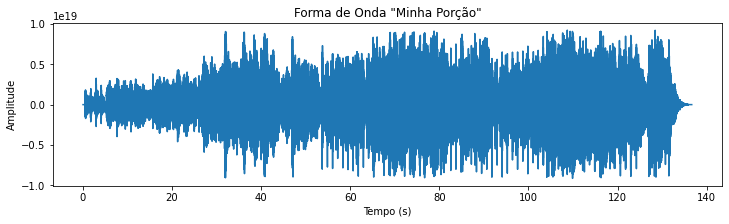

In [7]:
wav_filename = convert_mp3_to_wav("02 Minha porção.mp3")

spf = wave.open(wav_filename, "r")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "int64")
fs = spf.getframerate()


Time = np.linspace(0, len(signal) / fs, num=len(signal))

fig, ax = plt.subplots()
fig.set_size_inches(12,3)
plt.title("Signal Wave")
ax.plot(Time, signal)
ax.set(title='Forma de Onda "Minha Porção"',
      ylabel = 'Amplitude',
      xlabel = 'Tempo (s)')
plt.savefig('Waveform_Minha_Porcao.png')
plt.show()

In [10]:
def convert_wav_to_mp3(filename):
    sound = AudioSegment.from_wav(filename)
    filename = filename[:-4] + ".mp3"
    soundwav = sound.export(filename, format="mp3")
    soundwav.close()
    return filename

In [3]:
def generate_acm_mirum():

    acm_mirum_df = pd.DataFrame()

    acm_mirum = pd.read_csv("Banco de Dados/bpms_database/ACM_MIRUM.csv")

    acm_mirum = acm_mirum.rename(columns={'00000000':'filename', '00':'bpm'})


    list_of_files = os.listdir('Banco de Dados/acm_mirum_tempo')
    list_of_files = [file for file in list_of_files if file[-3:]=='mp3']

    start = time.time()
    i=0
    falhas=0
    total = len(list_of_files)
    for file in list_of_files:
        extension = file[-3:]

        if i==1410:
            continue

        if extension == 'wav':
            continue

        name = file[:-9]


        try:
            odf, pedf, ppedf, coefs = music_processor("Banco de Dados/acm_mirum_tempo/" +file)
            main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
            bpm = acm_mirum.loc[acm_mirum.filename == int(name)].iloc[0][1]

            dicionario['bpm'] = bpm
            dicionario['filename'] = file
            dicionario['database'] = 'acm_mirum'

            dic_df = pd.DataFrame(dicionario, index=[i])
            acm_mirum_df = pd.concat([acm_mirum_df, dic_df], sort=False)

        except Exception as e:
            print('Erro no processamento do arquivo '+ file)
            print(e)
            print()
            falhas = falhas + 1


        i=i+1
        porcentagem = 100*i/total
        print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    acm_mirum_df.to_csv('Banco de Dados/atributos/acm_mirum_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")
    
    return acm_mirum_df

def get_acm_mirum():
    return pd.read_csv('Banco de Dados/atributos/acm_mirum_atributos.csv')

In [4]:
def generate_eball():

    extended_ballroom_df = pd.DataFrame()

    extended_ballroom = pd.read_csv("Banco de Dados/bpms_database/EBALL.csv")

    extended_ballroom = extended_ballroom.rename(columns={'00000/000000':'filename', '00.0':'bpm'})

    list_of_folders = os.listdir('Banco de Dados/Ballroom')




    i=0
    falhas=0
    total = len(extended_ballroom)
    start = time.time()

    for folder in list_of_folders:
        list_of_files = os.listdir('Banco de Dados/Ballroom/'+folder)


        for file in list_of_files:

            name = folder+'/'+file[:-4]


            try:
                odf, pedf, ppedf, coefs = music_processor("Banco de Dados/Ballroom/" + folder + '/' + file)
                main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
                bpm = extended_ballroom.loc[extended_ballroom.filename == name].iloc[0][1]

                dicionario['bpm'] = bpm
                dicionario['filename'] = file
                dicionario['database'] = 'extended_ballroom'

                dic_df = pd.DataFrame(dicionario, index=[i])
                extended_ballroom_df = pd.concat([extended_ballroom_df, dic_df], sort=False)

            except Exception as e:
                #print('Erro no processamento do arquivo '+ file)
                #print(e)
                #print()
                falhas = falhas + 1
                continue


            i=i+1
            porcentagem = 100*i/total
            print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    extended_ballroom_df.to_csv('Banco de Dados/atributos/extended_ballroom_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")
     
    return extended_ballroom_df

def get_eball():
    return pd.read_csv('Banco de Dados/atributos/extended_ballroom_atributos.csv')

In [5]:
def generate_ismir():

    ismir2004_df = pd.DataFrame()

    ismir2004 = pd.read_csv('Banco de Dados/bpms_database/ISMIR2004.csv')

    ismir2004 = ismir2004.rename(columns={'0000':'filename', '000':'bpm'})

    list_of_folders = os.listdir('Banco de Dados/ismir2004_tempo')

    i=0
    falhas=0
    total = len(ismir2004)
    start = time.time()

    for folder in list_of_folders:
        list_of_files = os.listdir('Banco de dados/ismir2004_tempo/'+folder)

        for file in list_of_files:

            name = folder+'/'+file[:-4]


            try:
                new_file = convert_wav_to_mp3("Banco de Dados/ismir2004_tempo/" + folder + '/' + file)
                odf, pedf, ppedf, coefs = music_processor(new_file)
                main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
                bpm = ismir2004.loc[ismir2004.filename == name].iloc[0][1]

                dicionario['bpm'] = bpm
                dicionario['filename'] = file
                dicionario['database'] = 'ismir2004'

                dic_df = pd.DataFrame(dicionario, index=[i])
                ismir2004_df = pd.concat([ismir2004_df, dic_df], sort=False)

            except Exception as e:
                #print('Erro no processamento do arquivo '+ file)
                #print(e)
                #print()
                falhas = falhas + 1
                continue


            i=i+1
            porcentagem = 100*i/total
            print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    ismir2004_df.to_csv('Banco de Dados/atributos/ismir2004_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")
    
    return ismir2004_df

def get_ismir():
    return pd.read_csv('Banco de Dados/atributos/ismir2004_atributos.csv')

In [6]:
def generate_hainsworth():

    hainsworth_df = pd.DataFrame()

    hainsworth = pd.read_csv('Banco de Dados/bpms_database/HAINSWORTH.csv')

    hainsworth = hainsworth.rename(columns={'wavs/001':'filename', '99.9563':'bpm'})


    list_of_files = os.listdir('Banco de Dados/hainsworth_tempo_mp3')
    #list_of_files = [file for file in list_of_files if file[-3:]=='mp3']

    start = time.time()
    i=0
    falhas=0
    total = len(list_of_files)
    for file in list_of_files:

        name = file[:-4]


        try:
            odf, pedf, ppedf, coefs = music_processor("Banco de Dados/hainsworth_tempo_mp3/" +file)
            main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
            bpm = hainsworth.loc[hainsworth.filename == 'wavs/'+name].iloc[0][1]

            dicionario['bpm'] = bpm
            dicionario['filename'] = file
            dicionario['database'] = 'hainsworth'

            dic_df = pd.DataFrame(dicionario, index=[i])
            hainsworth_df = pd.concat([hainsworth_df, dic_df], sort=False)

        except Exception as e:
            print('Erro no processamento do arquivo '+ file)
            print(e)
            print()
            falhas = falhas + 1


        i=i+1
        porcentagem = 100*i/total
        print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    hainsworth_df.to_csv('Banco de Dados/atributos/hainsworth_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")
    
    return hainsworth_df

def get_hainsworth():
    return pd.read_csv('Banco de Dados/atributos/hainsworth_atributos.csv')

In [7]:
def generate_gtzan():

    gtzan_df = pd.DataFrame()

    gtzan = pd.read_csv('Banco de Dados/bpms_database/GTZAN_GENRES.csv')

    gtzan = gtzan.rename(columns={'00000000000':'filename', '000':'bpm'})


    list_of_files = os.listdir('Banco de Dados/gtzan_tempo')
    list_of_files = [file for file in list_of_files if file[-3:]=='wav']

    start = time.time()
    i=0
    falhas=0
    total = len(list_of_files)
    for file in list_of_files:

        name = file[:-4]

        new_file = convert_wav_to_mp3("Banco de Dados/gtzan_tempo/" + file)
        odf, pedf, ppedf, coefs = music_processor(new_file)
        main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
        bpm = gtzan.loc[gtzan.filename == 'wavs/'+name].iloc[0][1]

        try:
            new_file = convert_wav_to_mp3("Banco de Dados/gtzan_tempo/" + file)
            odf, pedf, ppedf, coefs = music_processor(new_file)
            main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
            bpm = gtzan.loc[gtzan.filename == 'wavs/'+name].iloc[0][1]

            dicionario['bpm'] = bpm
            dicionario['filename'] = file
            dicionario['database'] = 'gtzan'

            dic_df = pd.DataFrame(dicionario, index=[i])
            gtzan_df = pd.concat([gtzan_df, dic_df], sort=False)

        except Exception as e:
            print('Erro no processamento do arquivo '+ file)
            print(e)
            print()
            falhas = falhas + 1


        i=i+1
        porcentagem = 100*i/total
        print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    gtzan_df.to_csv('Banco de Dados/atributos/gtzan_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")
    
    return gtzan_df

def get_gtzan():
    return pd.read_csv('Banco de Dados/atributos/gtzan_atributos.csv')

In [8]:
def generate_smc_mirum():
    smc_mirum_df = pd.DataFrame()

    smc_mirum = pd.read_csv('Banco de Dados/bpms_database/SMC_MIRUM.csv')

    smc_mirum = smc_mirum.rename(columns={'0000000':'filename', '000000':'bpm'})


    list_of_files = os.listdir('Banco de Dados/smc_mirum_tempo')
    list_of_files = [file for file in list_of_files if file[-3:]=='wav']

    start = time.time()
    i=0
    falhas=0
    total = len(list_of_files)
    for file in list_of_files:

        name = file[:-4]

        try:
            new_file = convert_wav_to_mp3("Banco de Dados/smc_mirum_tempo/" + file)
            odf, pedf, ppedf, coefs = music_processor(new_file)
            main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
            bpm = smc_mirum.loc[smc_mirum.filename == name].iloc[0][1]

            dicionario['bpm'] = bpm
            dicionario['filename'] = file
            dicionario['database'] = 'smc_mirum'

            dic_df = pd.DataFrame(dicionario, index=[i])
            smc_mirum_df = pd.concat([smc_mirum_df, dic_df], sort=False)

        except Exception as e:
            print('Erro no processamento do arquivo '+ file)
            print(e)
            print()
            falhas = falhas + 1


        i=i+1
        porcentagem = 100*i/total
        print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    smc_mirum_df.to_csv('Banco de Dados/atributos/smc_mirum_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")
    
    return smc_mirum_df

def get_smc_mirum():
    return pd.read_csv('Banco de Dados/atributos/smc_mirum_atributos.csv')

In [21]:
def generate_lmd():

    lmd_df = pd.DataFrame()

    lmd = pd.read_csv('Banco de Dados/bpms_database/LMD.csv')

    list_of_files = os.listdir('Banco de Dados/LMD_WAV')
    list_of_files = [file for file in list_of_files if file[-3:]=='wav']

    start = time.time()
    i=0
    falhas=0
    total = len(list_of_files)

    for file in list_of_files:
        
        name = file[:-4]

        #try:
        new_file = convert_wav_to_mp3("Banco de Dados/LMD_WAV/" + file)
        odf, pedf, ppedf, coefs = music_processor(new_file)
        main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
        bpm = lmd.loc[lmd.filename[6:] == name].iloc[0][1]

        dicionario['bpm'] = bpm
        dicionario['filename'] = file
        dicionario['database'] = 'smc_mirum'

        dic_df = pd.DataFrame(dicionario, index=[i])
        lmd_df = pd.concat([lmd_df, dic_df], sort=False)
        '''
        except Exception as e:
            print('Erro no processamento do arquivo '+ file)
            print(e)
            print()
            falhas = falhas + 1
        '''

        i=i+1
        porcentagem = 100*i/total
        print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    lmd_df.to_csv('Banco de Dados/atributos/lmd_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")

    return lmd_df


def get_lmd():
    return pd.read_csv('Banco de Dados/atributos/lmd_atributos.csv')

generate_lmd()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [9]:
def generate_banco2():

    banco2_df = pd.DataFrame()

    banco2 = pd.read_excel('Banco de Dados/bpms_database/BPM Banco de Dados1e2.xlsx', sheet_name = 'Banco 2 Indexado')


    banco2 = pd.DataFrame(banco2['BPM Tapping'])
    banco2 = banco2.reset_index(level=1)
    banco2 = banco2[1:201]
    banco2 = banco2.rename(columns={'level_1':'filename', 'BPM Tapping': 'bpm'})


    list_of_files = os.listdir('Banco de Dados/Banco de Dados 2 V1')
    list_of_files = [file for file in list_of_files if file[-3:]=='wav']

    start = time.time()
    i=0
    falhas=0
    total = len(list_of_files)
    for file in list_of_files:

        name = file[:-4]

        try:
            new_file = convert_wav_to_mp3("Banco de Dados/Banco de Dados 2 V1/" + file)
            odf, pedf, ppedf, coefs = music_processor(new_file)
            main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
            bpm = banco2.iloc[int(name)-1][1]

            dicionario['bpm'] = bpm
            dicionario['filename'] = file
            dicionario['database'] = 'banco2'

            dic_df = pd.DataFrame(dicionario, index=[i])
            banco2_df = pd.concat([banco2_df, dic_df], sort=False)

        except Exception as e:
            print('Erro no processamento do arquivo '+ file)
            print(e)
            print()
            falhas = falhas + 1


        i=i+1
        porcentagem = 100*i/total
        print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    banco2_df.to_csv('Banco de Dados/atributos/banco2_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")
    
    return banco2_df

def get_banco2():
    banco2 = pd.read_csv('Banco de Dados/atributos/banco2_atributos.csv')
    return banco2

In [10]:
def generate_banco1():

    banco1_df = pd.DataFrame()

    banco1 = pd.read_excel('Banco de Dados/bpms_database/BPM Banco de Dados1e2.xlsx', sheet_name = 'Banco 1 Corrigido')

    banco1 = pd.DataFrame(banco1['Unnamed: 1'], banco1['Unnamed: 5'])
    #banco1_bpm = pd.DataFrame(banco1['Unnamed: 5'])

    banco1 = banco1.reset_index(level=0)
    banco1 = banco1[1:308]
    banco1 = banco1.rename(columns={'Unnamed: 1':'filename', 'Unnamed: 5': 'bpm'})


    list_of_files = os.listdir('Banco de Dados/Banco de Dados 1 Corrigido')
    list_of_files = [file for file in list_of_files if file[-3:]=='wav']

    start = time.time()
    i=0
    falhas=0
    total = len(list_of_files)
    for file in list_of_files:

        name = file[:-4]

        try:
            new_file = convert_wav_to_mp3("Banco de Dados/Banco de Dados 1 Corrigido/" + file)
            odf, pedf, ppedf, coefs = music_processor(new_file)
            main_d, dicionario = ECA(pedf, wich_not=['v_pr', 'v_erf1'])
            bpm = banco1.iloc[int(name)-1][0]

            dicionario['bpm'] = bpm
            dicionario['filename'] = file
            dicionario['database'] = 'banco1'

            dic_df = pd.DataFrame(dicionario, index=[i])
            banco1_df = pd.concat([banco1_df, dic_df], sort=False)

        except Exception as e:
            print('Erro no processamento do arquivo '+ file)
            print(e)
            print()
            falhas = falhas + 1


        i=i+1
        porcentagem = 100*i/total
        print(str(i)+'/'+str(total)+' arquivos processados, que significam: '+str(porcentagem)+'%', end='\r')

    end = time.time()
    banco1_df.to_csv('Banco de Dados/atributos/banco1_atributos.csv')

    print(f"{i-falhas} arquivos processados com sucesso.\nHouveram {falhas} arquivos corrompidos ou inexistentes.\nO tempo decorrido foi de {end-start} segundos.")
    
    return banco1_df

def get_banco1():
    banco1 = pd.read_csv('Banco de Dados/atributos/banco1_atributos.csv')
    return banco1


KeyboardInterrupt: 